# **Packages Installation**

## **Imports**

In [ ]:
import torch
import requests
import torch.nn as nn
import numpy as np
import time
import torch.optim as optim
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset

# **Problem 2 Starts Here**

In [ ]:
# The Public URL for the Tiny Shakespeare dataset
url = "https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt"

# Download the dataset
response = requests.get(url)
shakespare_data = response.text


print(shakespare_data[:250])

First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You are all resolved rather to die than to famish?

All:
Resolved. resolved.

First Citizen:
First, you know Caius Marcius is chief enemy to the people.



In [ ]:
unique_chars = sorted(list(set(shakespare_data)))
char_to_index = {ch: i for i, ch in enumerate(unique_chars)}
index_to_char = {i: ch for i, ch in enumerate(unique_chars)}
input_size = output_size = len(unique_chars)


# Encoding the sequence
def encode_sequence(seq):
    return [char_to_index[char] for char in seq]

# Preparing training data
def create_training_data(sequence, seq_length):
    sequences = []
    next_chars = []
    for i in range(len(sequence) - seq_length):
        sequences.append(encode_sequence(sequence[i: i + seq_length]))
        next_chars.append(char_to_index[sequence[i + seq_length]])
    return torch.tensor(sequences, dtype=torch.long), torch.tensor(next_chars, dtype=torch.long)

def train_val_split(sequences, targets, split_ratio=0.8):
    # Determine the split index
    idx = int(len(sequences) * split_ratio)

    # Split the sequences and targets into training and validation sets
    train_sequences, train_targets = sequences[:idx], targets[:idx]
    val_sequences, val_targets = sequences[idx:], targets[idx:]

    return train_sequences, train_targets, val_sequences, val_targets


class CharDataset(Dataset):
    def __init__(self, sequences, targets):
        self.sequences = sequences
        self.targets = targets

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        return self.sequences[idx], self.targets[idx]


sequences_20, targets_20 = create_training_data(shakespare_data, 20)
sequences_30, targets_30 = create_training_data(shakespare_data, 30)

# Convert to PyTorch tensors
sequences_20 = torch.tensor(sequences_20, dtype=torch.long)
targets_20 = torch.tensor(targets_20, dtype=torch.long)
sequences_30 = torch.tensor(sequences_30, dtype=torch.long)
targets_30 = torch.tensor(targets_30, dtype=torch.long)

train_sequences_20, train_targets_20, val_sequences_20, val_targets_20 = train_val_split(sequences_20, targets_20)
train_sequences_30, train_targets_30, val_sequences_30, val_targets_30 = train_val_split(sequences_30, targets_30)


<ipython-input-3-eb7740f8c552>:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  sequences_20 = torch.tensor(sequences_20, dtype=torch.long)
<ipython-input-3-eb7740f8c552>:48: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets_20 = torch.tensor(targets_20, dtype=torch.long)
<ipython-input-3-eb7740f8c552>:49: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  sequences_30 = torch.tensor(sequences_30, dtype=torch.long)
<ipython-input-3-eb7740f8c552>:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone(

In [ ]:
batch_size = 64

train_dataset_20 = CharDataset(train_sequences_20, train_targets_20)
train_dataloader_20 = DataLoader(train_dataset_20, batch_size=batch_size, shuffle=True, drop_last=True)
val_dataset_20 = CharDataset(val_sequences_20, val_targets_20)
val_dataloader_20 = DataLoader(val_dataset_20, batch_size=batch_size, shuffle=False, drop_last=True)


train_dataset_30 = CharDataset(train_sequences_30, train_targets_30)
train_dataloader_30 = DataLoader(train_dataset_30, batch_size=batch_size, shuffle=True, drop_last=True)
val_dataset_30 = CharDataset(val_sequences_30, val_targets_30)
val_dataloader_30 = DataLoader(val_dataset_30, batch_size=batch_size, shuffle=False, drop_last=True)

# **Model Development**

In [ ]:
class LSTMModel(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_size, output_size, num_layers=1):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.embed = nn.Embedding(vocab_size, embed_dim)
        self.lstm = nn.LSTM(embed_dim, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = self.embed(x)
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.lstm(x, (h0, c0))
        out = F.relu(out[:, -1, :])
        out = self.fc(out)
        return out


class GRUModel(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_size, output_size, num_layers=1):
        super(GRUModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.embed = nn.Embedding(vocab_size, embed_dim)
        self.gru = nn.GRU(embed_dim, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = self.embed(x)
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.gru(x, h0)
        out = F.relu(out[:, -1, :])
        out = self.fc(out)
        return out

In [ ]:
def train_and_validate(model, train_dataloader, val_dataloader, num_epochs=20, learning_rate=0.0001):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=0.001)

    # Tracking metrics
    history = {
        "train_loss": [],
        "val_loss": [],
        "val_accuracy": []
    }

    start_time = time.time()

    for epoch in range(num_epochs):
        model.train()
        total_loss = 0
        for sequences, targets in train_dataloader:
            sequences, targets = sequences.to(device), targets.to(device)
            optimizer.zero_grad()
            output = model(sequences)
            loss = criterion(output.view(-1, output.size(-1)), targets.view(-1))


            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        avg_train_loss = total_loss / len(train_dataloader)
        history["train_loss"].append(avg_train_loss)

        # Validation
        model.eval()
        total_val_loss = 0
        correct_preds = 0
        total_preds = 0

        with torch.no_grad():
            for sequences, targets in val_dataloader:
                sequences, targets = sequences.to(device), targets.to(device)
                output = model(sequences)
                loss = criterion(output.view(-1, output.size(-1)), targets.view(-1))
                total_val_loss += loss.item()

                _, preds = torch.max(output, dim=-1)
                correct_preds += (preds == targets).sum().item()
                total_preds += targets.numel()

        avg_val_loss = total_val_loss / len(val_dataloader)
        val_accuracy = correct_preds / total_preds

        history["val_loss"].append(avg_val_loss)
        history["val_accuracy"].append(val_accuracy)

        print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}")

    end_time = time.time()
    training_time = end_time - start_time
    print(f"Training completed in {training_time:.2f} seconds.")

    return history, training_time


def plot_metrics(history):
    epochs = range(1, len(history['train_loss']) + 1)

    plt.figure(figsize=(15, 7))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, history['train_loss'], label='Training Loss')
    plt.plot(epochs, history['val_loss'], label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.plot(epochs, history['val_accuracy'], label='Validation Accuracy', color='green')
    plt.title('Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

In [ ]:
lstm_model = LSTMModel(vocab_size=input_size, embed_dim=64, hidden_size=64, output_size=output_size, num_layers=1)
gru_model = GRUModel(vocab_size=input_size, embed_dim=64, hidden_size=64, output_size=output_size, num_layers=1)

Epoch 1/20 - Train Loss: 2.6294, Val Loss: 2.4093, Val Accuracy: 0.3220
Epoch 2/20 - Train Loss: 2.3499, Val Loss: 2.3245, Val Accuracy: 0.3405
Epoch 3/20 - Train Loss: 2.2844, Val Loss: 2.2760, Val Accuracy: 0.3542
Epoch 4/20 - Train Loss: 2.2423, Val Loss: 2.2423, Val Accuracy: 0.3653
Epoch 5/20 - Train Loss: 2.2115, Val Loss: 2.2166, Val Accuracy: 0.3711
Epoch 6/20 - Train Loss: 2.1890, Val Loss: 2.1987, Val Accuracy: 0.3763
Epoch 7/20 - Train Loss: 2.1719, Val Loss: 2.1857, Val Accuracy: 0.3779
Epoch 8/20 - Train Loss: 2.1586, Val Loss: 2.1732, Val Accuracy: 0.3795
Epoch 9/20 - Train Loss: 2.1477, Val Loss: 2.1647, Val Accuracy: 0.3829
Epoch 10/20 - Train Loss: 2.1383, Val Loss: 2.1585, Val Accuracy: 0.3848
Epoch 11/20 - Train Loss: 2.1305, Val Loss: 2.1504, Val Accuracy: 0.3854
Epoch 12/20 - Train Loss: 2.1235, Val Loss: 2.1443, Val Accuracy: 0.3868
Epoch 13/20 - Train Loss: 2.1178, Val Loss: 2.1396, Val Accuracy: 0.3874
Epoch 14/20 - Train Loss: 2.1123, Val Loss: 2.1370, Val Accu

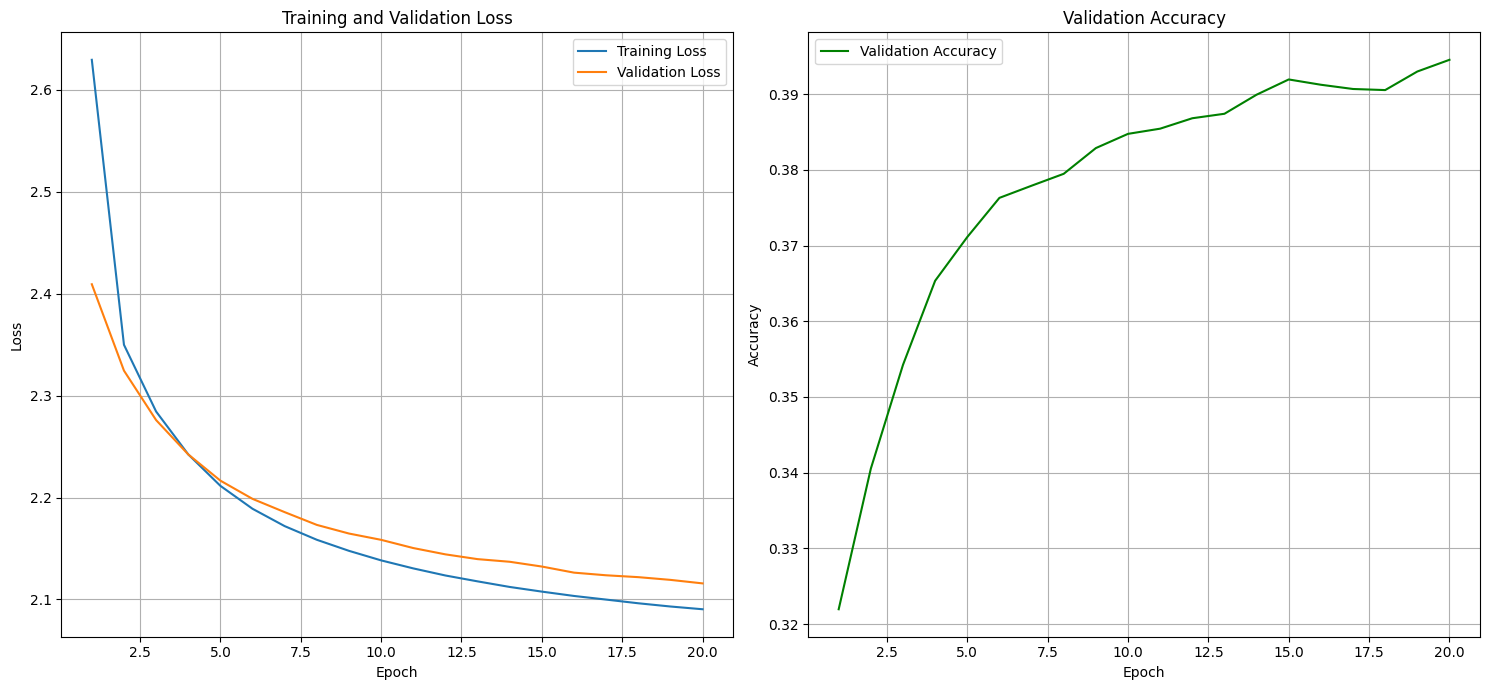

In [ ]:
metrics_20, training_time = train_and_validate(model=lstm_model, train_dataloader=train_dataloader_20, val_dataloader=val_dataloader_20)
plot_metrics(metrics_20)

Epoch 1/20 - Train Loss: 2.0834, Val Loss: 2.1113, Val Accuracy: 0.3962
Epoch 2/20 - Train Loss: 2.0800, Val Loss: 2.1096, Val Accuracy: 0.3947
Epoch 3/20 - Train Loss: 2.0774, Val Loss: 2.1060, Val Accuracy: 0.3962
Epoch 4/20 - Train Loss: 2.0752, Val Loss: 2.1058, Val Accuracy: 0.3962
Epoch 5/20 - Train Loss: 2.0733, Val Loss: 2.1034, Val Accuracy: 0.3976
Epoch 6/20 - Train Loss: 2.0714, Val Loss: 2.1045, Val Accuracy: 0.3979
Epoch 7/20 - Train Loss: 2.0697, Val Loss: 2.1032, Val Accuracy: 0.3993
Epoch 8/20 - Train Loss: 2.0681, Val Loss: 2.1003, Val Accuracy: 0.3982
Epoch 9/20 - Train Loss: 2.0667, Val Loss: 2.0979, Val Accuracy: 0.3984
Epoch 10/20 - Train Loss: 2.0655, Val Loss: 2.0970, Val Accuracy: 0.4004
Epoch 11/20 - Train Loss: 2.0640, Val Loss: 2.0971, Val Accuracy: 0.4002
Epoch 12/20 - Train Loss: 2.0629, Val Loss: 2.0965, Val Accuracy: 0.4004
Epoch 13/20 - Train Loss: 2.0619, Val Loss: 2.0949, Val Accuracy: 0.4006
Epoch 14/20 - Train Loss: 2.0607, Val Loss: 2.0978, Val Accu

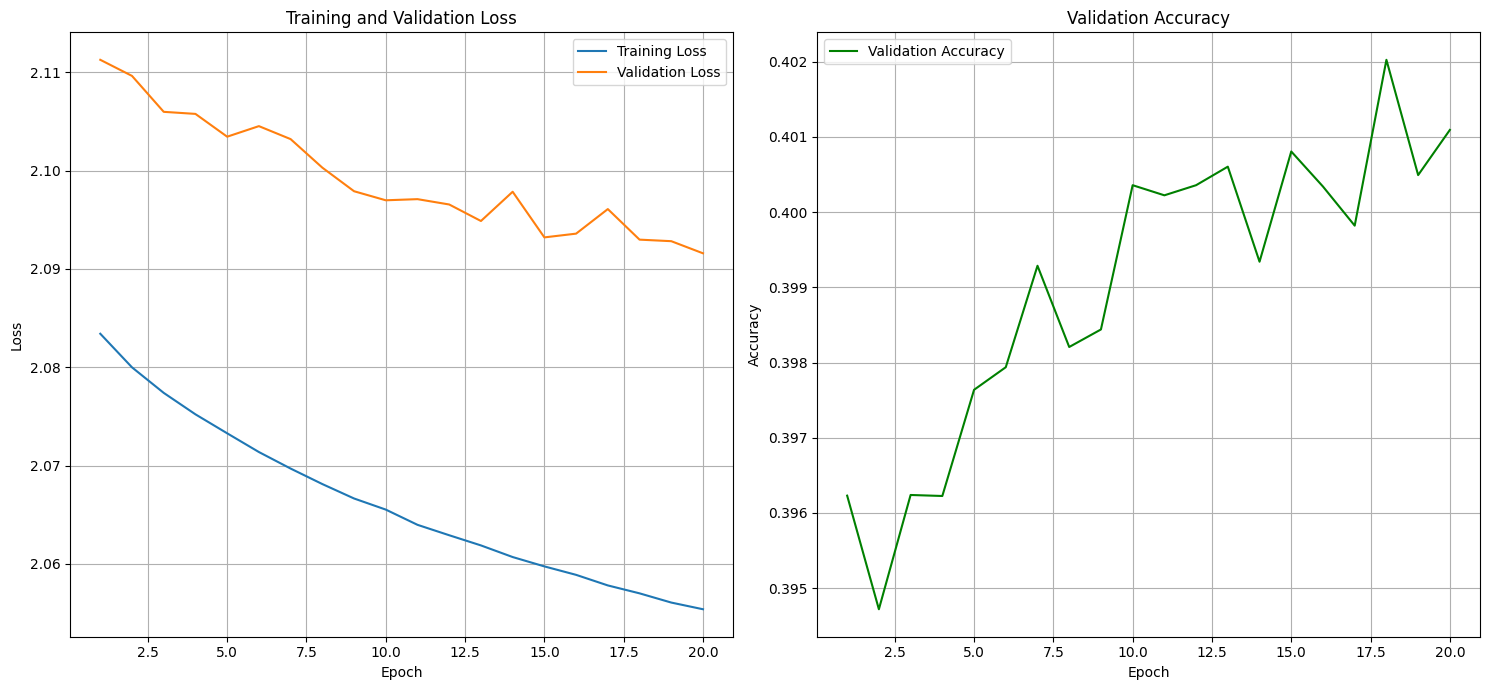

In [9]:
metrics_30, training_time = train_and_validate(model=lstm_model, train_dataloader=train_dataloader_30, val_dataloader=val_dataloader_30)
plot_metrics(metrics_30)

# **GRU Model**

Epoch 1/20 - Train Loss: 2.5566, Val Loss: 2.3367, Val Accuracy: 0.3361
Epoch 2/20 - Train Loss: 2.2679, Val Loss: 2.2407, Val Accuracy: 0.3645
Epoch 3/20 - Train Loss: 2.1964, Val Loss: 2.1933, Val Accuracy: 0.3753
Epoch 4/20 - Train Loss: 2.1549, Val Loss: 2.1623, Val Accuracy: 0.3839
Epoch 5/20 - Train Loss: 2.1275, Val Loss: 2.1400, Val Accuracy: 0.3859
Epoch 6/20 - Train Loss: 2.1067, Val Loss: 2.1250, Val Accuracy: 0.3908
Epoch 7/20 - Train Loss: 2.0900, Val Loss: 2.1113, Val Accuracy: 0.3934
Epoch 8/20 - Train Loss: 2.0763, Val Loss: 2.1016, Val Accuracy: 0.3963
Epoch 9/20 - Train Loss: 2.0651, Val Loss: 2.0920, Val Accuracy: 0.3976
Epoch 10/20 - Train Loss: 2.0556, Val Loss: 2.0835, Val Accuracy: 0.4019
Epoch 11/20 - Train Loss: 2.0474, Val Loss: 2.0786, Val Accuracy: 0.4014
Epoch 12/20 - Train Loss: 2.0401, Val Loss: 2.0729, Val Accuracy: 0.4033
Epoch 13/20 - Train Loss: 2.0335, Val Loss: 2.0688, Val Accuracy: 0.4044
Epoch 14/20 - Train Loss: 2.0278, Val Loss: 2.0627, Val Accu

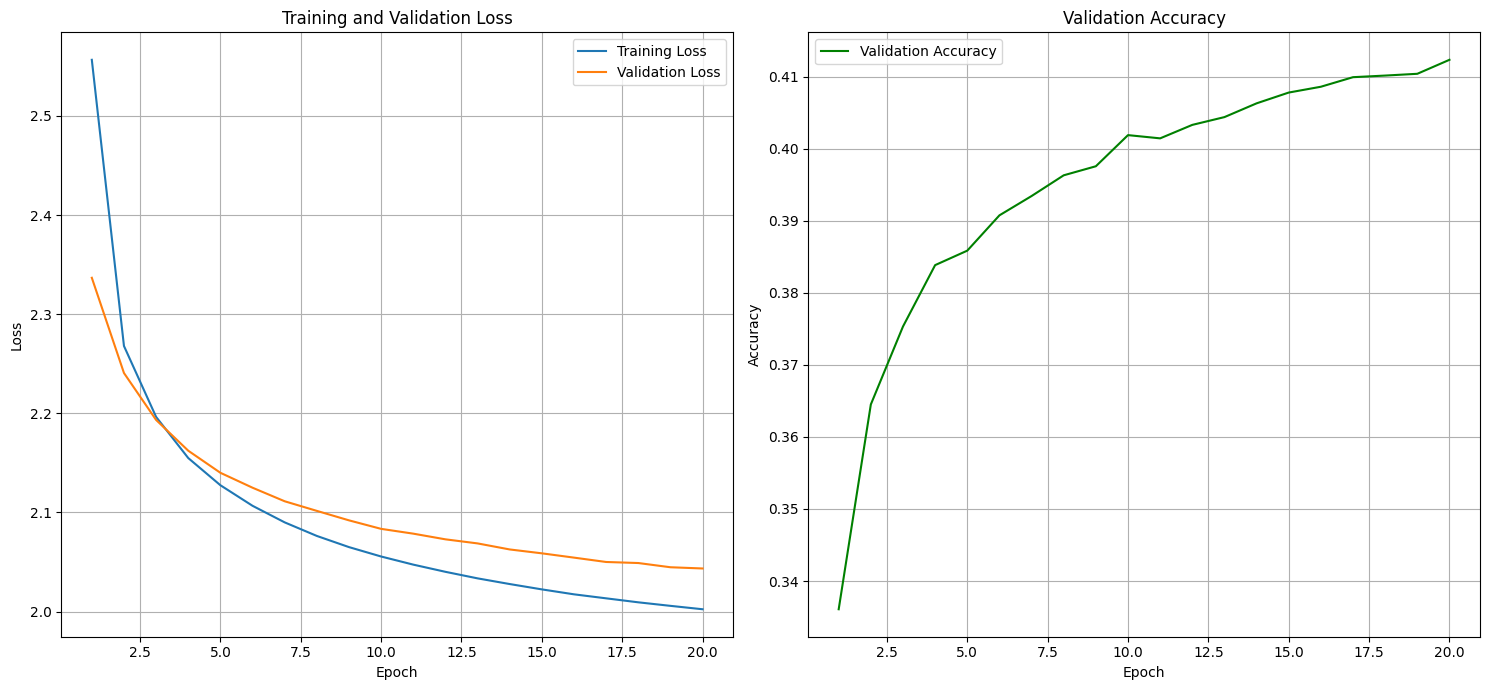

In [10]:
metrics_20, training_time = train_and_validate(model=gru_model, train_dataloader=train_dataloader_20, val_dataloader=val_dataloader_20)
plot_metrics(metrics_20)

Epoch 1/20 - Train Loss: 1.9993, Val Loss: 2.0416, Val Accuracy: 0.4107
Epoch 2/20 - Train Loss: 1.9963, Val Loss: 2.0381, Val Accuracy: 0.4127
Epoch 3/20 - Train Loss: 1.9938, Val Loss: 2.0359, Val Accuracy: 0.4129
Epoch 4/20 - Train Loss: 1.9911, Val Loss: 2.0327, Val Accuracy: 0.4126
Epoch 5/20 - Train Loss: 1.9887, Val Loss: 2.0299, Val Accuracy: 0.4150
Epoch 6/20 - Train Loss: 1.9866, Val Loss: 2.0294, Val Accuracy: 0.4149
Epoch 7/20 - Train Loss: 1.9846, Val Loss: 2.0266, Val Accuracy: 0.4158
Epoch 8/20 - Train Loss: 1.9826, Val Loss: 2.0272, Val Accuracy: 0.4163
Epoch 9/20 - Train Loss: 1.9806, Val Loss: 2.0247, Val Accuracy: 0.4166
Epoch 10/20 - Train Loss: 1.9789, Val Loss: 2.0239, Val Accuracy: 0.4167
Epoch 11/20 - Train Loss: 1.9772, Val Loss: 2.0218, Val Accuracy: 0.4171
Epoch 12/20 - Train Loss: 1.9754, Val Loss: 2.0212, Val Accuracy: 0.4177
Epoch 13/20 - Train Loss: 1.9737, Val Loss: 2.0185, Val Accuracy: 0.4191
Epoch 14/20 - Train Loss: 1.9724, Val Loss: 2.0182, Val Accu

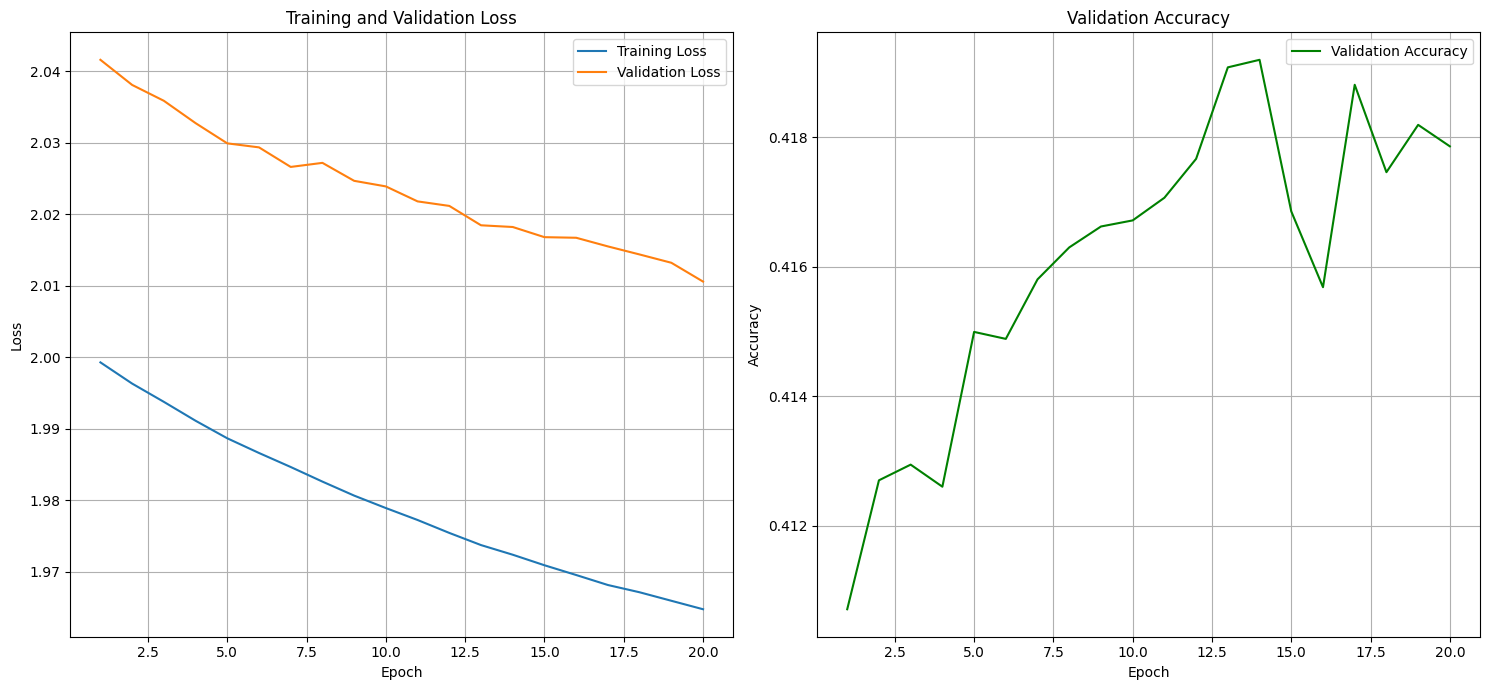

In [11]:
metrics_30, training_time = train_and_validate(model=gru_model, train_dataloader=train_dataloader_30, val_dataloader=val_dataloader_30)
plot_metrics(metrics_30)